### Carregando os arquivo para geração do modelo

In [1]:
import hdbscan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Carrega no Dataframe somente os dados que serão usados para treinar o modelo
df = pd.read_csv('indicadores2-07-11.csv')[['vl_licitacao','indicador1','indicador2']]
df.shape

(2960, 3)

In [3]:
# Visualizando algumas linhas iniciais dos dados carregados
df[:5]

,vl_licitacao,indicador1,indicador2
0,7000.0,0.917143,1
1,300000.0,1.000010,1
2,44000.0,1.000000,0
3,18000.0,1.000000,0
4,46920.0,0.408696,0


#### Desativando o scaling dos dados
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
scaled_array = min_max_scaler.fit_transform(df.values.astype(float))
df_normalized = pd.DataFrame(scaled_array)
df_normalized[:5]

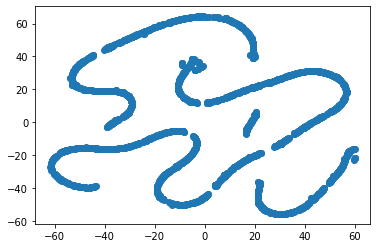

In [9]:
# Visuzalisando o gráfico dos dados de treinamento antes de clusterizar
from sklearn.manifold import TSNE

data = df.to_numpy()
projection = TSNE().fit_transform(data)
plt.scatter(*projection.T)

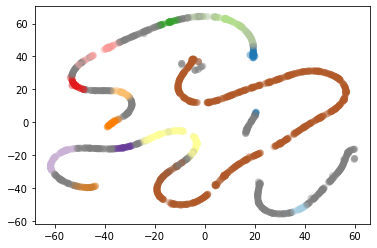

In [10]:
# Treinando o modelo
clusterer = hdbscan.HDBSCAN(min_cluster_size=35, prediction_data=True).fit(data)

# Visualizando os dados após clusterização
color_palette = sns.color_palette('Paired', 12)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]
plt.scatter(*projection.T, s=50, linewidth=0, c=cluster_member_colors, alpha=0.25)

In [15]:
### Salvando dados do modelo em arquivo
import pickle

with open('hdbscan-model.pkl', 'wb') as output:
    pickle.dump(clusterer, output, pickle.HIGHEST_PROTOCOL)

with open('hdbscan-projection_params.pkl', 'wb') as output:
    pickle.dump(data, output, pickle.HIGHEST_PROTOCOL)

with open('hdbscan-projection.pkl', 'wb') as output:
    pickle.dump(projection, output, pickle.HIGHEST_PROTOCOL)

## Código para forçar classificação dos sem grupo

soft_clusters = hdbscan.all_points_membership_vectors(clusterer)
color_palette = sns.color_palette('Paired', 12)
cluster_colors = [color_palette[np.argmax(x)]
                  for x in soft_clusters]
plt.scatter(*projection.T, s=50, linewidth=0, c=cluster_colors, alpha=0.25)

### Outliar Detection

data = np.load('clusterable_data.npy')
plt.scatter(*data.T, s=50, linewidth=0, c='b', alpha=0.25)

clusterer = hdbscan.HDBSCAN(min_cluster_size=15).fit(data)
sns.distplot(clusterer.outlier_scores_[np.isfinite(clusterer.outlier_scores_)], rug=True)

import pandas as pd
threshold = pd.Series(clusterer.outlier_scores_).quantile(0.9)
outliers = np.where(clusterer.outlier_scores_ > threshold)[0]
plt.scatter(*data.T, s=50, linewidth=0, c='gray', alpha=0.25)
plt.scatter(*data[outliers].T, s=50, linewidth=0, c='red', alpha=0.5)